## Keras model Application

keras에서는 유명 모델을 쉽게 사용할 수 있도록 함수로 제공하고 있다. 사용할 수 있는 모델의 종류는 다음과 같으며,
[keras, application](https://keras.io/applications/)에서 확인 할 수 있다.

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet
* MobileNetV2

이 중에서 vgg16 모델을 load해서 test하고 conv layer를 지나가면서 image가 어떻게 변형되는지 볼 것이다.

#### Reference(참고 사이트)

* Keras documnet : https://keras.io/applications/#vgg16<br>
* https://github.com/ilguyi/tensorflow.tutorials/blob/master/tf.version.2/03.cnn/04.vgg16.ipynb 의 코드를 참고하여 작성<br>
* VGG16 paper : https://arxiv.org/abs/1512.03385<br>
* Keras github code : https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py
* https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
* https://www.kaggle.com/gaborfodor/resnet50-example

## 1.Setup

In [1]:
from __future__ import absolute_import, print_function, division

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from keras.applications.imagenet_utils import decode_predictions

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

tf.enable_eager_execution()
print(tf.__version__)

C:\Users\home\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1.12.0


## 2. Load VGG16 

VGG16을 load 할 때 필요한 argument는 다음과 같다.

### Arguments
* `include_top`: whether to include the 3 fully-connected layers at the top of the network.
* `weights`: one of None (random initialization) or 'imagenet' (pre-training on ImageNet).
* `input_tensor`: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
* `input_shape`: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
* `pooling`: Optional pooling mode for feature extraction when include_top is False.
    * None means that the output of the model will be the 4D tensor output of the last convolutional layer.
    * 'avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor.
    * 'max' means that global max pooling will be applied.
* `classes`: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.

여기서 `include_top` code를 살펴보면 아래와 같이 정의되어 있으며, include_top=True이면 model의 마지막에 Dense layer를 통과하게 된다.


```    
if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        x = layers.Dense(4096, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
```

In [2]:
vgg16 = keras.applications.VGG16(weights=None) #default weight는 'imagenet'으로 설정되어 있다.

In [3]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## 3. Data Preparation

sample image를 하나 불러오고 크기를 확인해보자.

Text(0.5,1,'Sampel cat image(274 * 184)')

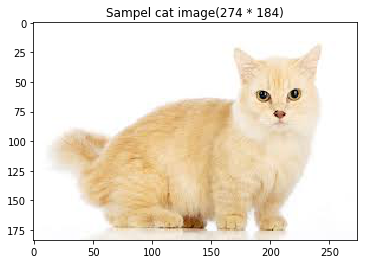

In [4]:
sample_img = Image.open('./input/cat2.jpg')

plt.imshow(sample_img)
plt.title("Sampel cat image({} * {})".format(sample_img.width, sample_img.height))

#### Data preprocessing
1. Input shape
2. Set data type np.float32
3. Change image scale 0~255 to 0~1.
4. Add dimension 

In [5]:
#기존의 VGG16의 전처리 과정에서는 255로 나누지 않고 norm_mean으로 나눠서 평균만 0으로 맞춰준다.
def image_pre(img): #input PIL image data
    img_size = 224
    img = img.resize((img_size, img_size))
    img = np.array(img) / 255
    img = img.astype(np.float32)
    
    return img

In [6]:
pre_img = image_pre(sample_img)
pre_img = np.expand_dims(pre_img, axis=0) #[-1, 224, 224, 3]

In [7]:
pre_img.shape

(1, 224, 224, 3)

직접 함수를 정의해서 image preprocessing을 할 수도 있지만,<br> 
Keras documnet ['Extract features with VGG16'](https://keras.io/applications/)에서는 다른 방법으로 image preprocessing을 진행한다.
과정은 다음과 같다.

In [8]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [9]:
img_path = './input/cat2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [10]:
x.shape

(1, 224, 224, 3)

model에 image를 넣고 prediction을 실행해보자.

In [11]:
pred_1 = vgg16.predict(x)

In [12]:
print(pred_1.shape)
decode_predictions(pred_1, top=5)

(1, 1000)


[[('n03977966', 'police_van', 0.0027257332),
  ('n04254680', 'soccer_ball', 0.0023214421),
  ('n02892201', 'brass', 0.0022373833),
  ('n07754684', 'jackfruit', 0.0020058837),
  ('n03240683', 'drilling_platform', 0.001980222)]]

## 4. Predict pre-trained weight model

imagenet dataset으로 pre-trained weight를 불러와서 prediction해보자.

In [13]:
vgg16_2 = keras.applications.VGG16(weights='imagenet')

In [14]:
pred_2 = vgg16_2.predict(x)

In [15]:
decode_predictions(pred_2, top=5)

[[('n02123394', 'Persian_cat', 0.5071553),
  ('n02124075', 'Egyptian_cat', 0.12799473),
  ('n02127052', 'lynx', 0.06322147),
  ('n02123045', 'tabby', 0.042913895),
  ('n02123159', 'tiger_cat', 0.024058605)]]

## 5. Observe feature maps

### 4.1 Layer output

각 layer를 통과하고 나오는 output을 확인해보자.<br>
`layer.output`으로 각 layer의 결과값을 저장할 수 있는 새로운 모델을 하나 정의할 것이다. 구조는 vgg16과 동일하다.

In [20]:
layer_output = [layer.output for layer in vgg16_2.layers[1:]]

for layer in layer_output:
    print(layer)

DeferredTensor('None', shape=(?, 224, 224, 64), dtype=float32)
DeferredTensor('None', shape=(?, 224, 224, 64), dtype=float32)
DeferredTensor('None', shape=(?, 112, 112, 64), dtype=float32)
DeferredTensor('None', shape=(?, 112, 112, 128), dtype=float32)
DeferredTensor('None', shape=(?, 112, 112, 128), dtype=float32)
DeferredTensor('None', shape=(?, 56, 56, 128), dtype=float32)
DeferredTensor('None', shape=(?, 56, 56, 256), dtype=float32)
DeferredTensor('None', shape=(?, 56, 56, 256), dtype=float32)
DeferredTensor('None', shape=(?, 56, 56, 256), dtype=float32)
DeferredTensor('None', shape=(?, 28, 28, 256), dtype=float32)
DeferredTensor('None', shape=(?, 28, 28, 512), dtype=float32)
DeferredTensor('None', shape=(?, 28, 28, 512), dtype=float32)
DeferredTensor('None', shape=(?, 28, 28, 512), dtype=float32)
DeferredTensor('None', shape=(?, 14, 14, 512), dtype=float32)
DeferredTensor('None', shape=(?, 14, 14, 512), dtype=float32)
DeferredTensor('None', shape=(?, 14, 14, 512), dtype=float32)
D

In [22]:
activation_model = models.Model(inputs=vgg16_2.input, outputs=layer_output)

In [23]:
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

sample image를 모델에 통과시키고, 확인하고자 하는 layer의 결과를 따로 모은다.

In [24]:
activations = activation_model.predict(x)

In [25]:
conv1_1 = activations[0]
conv2_1 = activations[2]
conv3_2 = activations[6]
conv4_3 = activations[11]
conv5_3 = activations[15]

feature map을 출력할 함수를 정의한다.

In [26]:
def print_all_feature_maps(layer, layer_name):
  """Print all feature maps
    This code is borrowed from "Deep Learning with Python" (by F. Chollet)
  
  Args:
    layer (4-rank Tensor): feature maps
    layer_name (string): name of feature maps
    
  Returns:
    print all feature maps
  """
  num_features = layer.shape[-1]
  size = layer.shape[1]
  images_per_row = 16
  for feature_map in range(num_features):
    num_cols = num_features // images_per_row
    display_grid = np.zeros((size * num_cols, images_per_row * size))

    for col in range(num_cols):
      for row in range(images_per_row):
        channel_image = layer[0,:,:,col * images_per_row + row]

        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

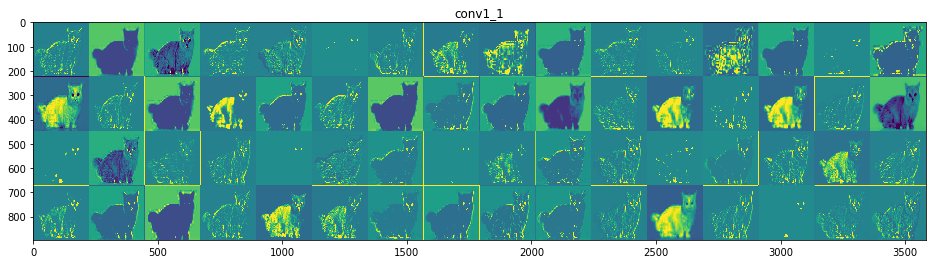

In [27]:
print_all_feature_maps(conv1_1, 'conv1_1')

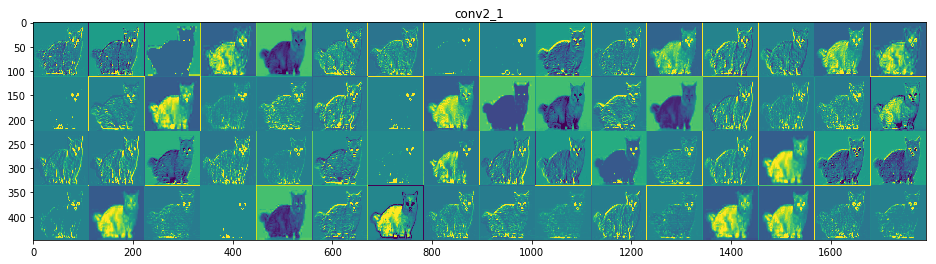

In [28]:
print_all_feature_maps(conv2_1, 'conv2_1')

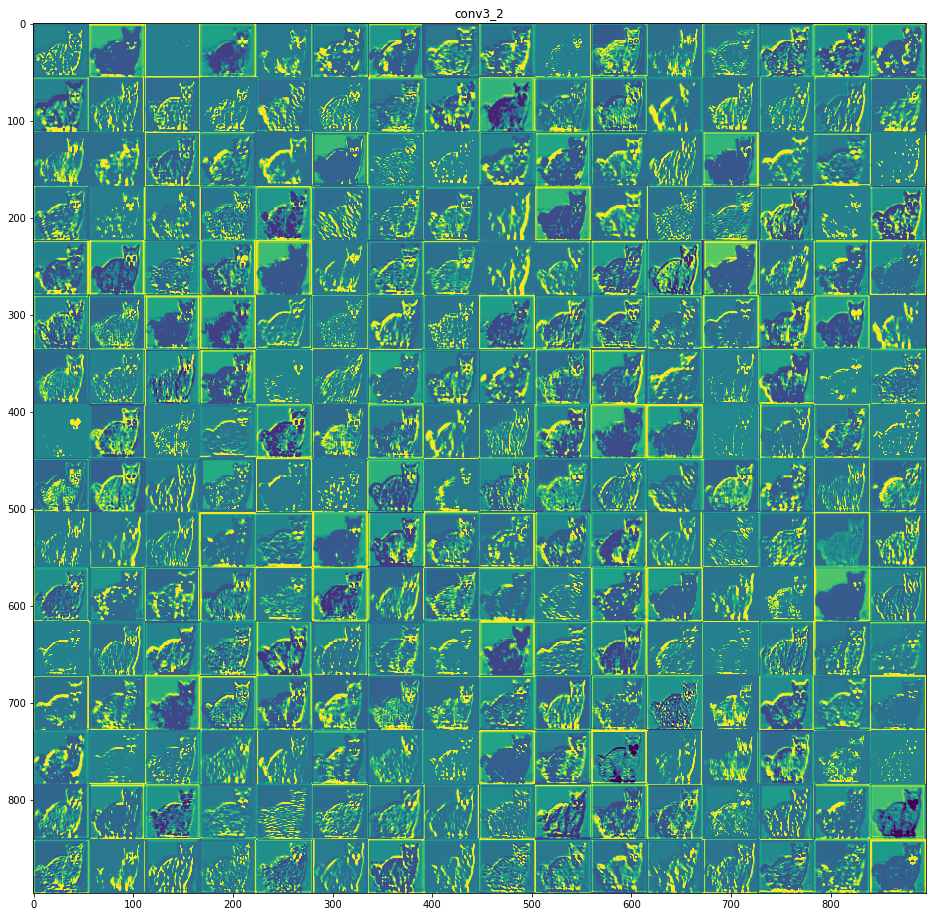

In [29]:
print_all_feature_maps(conv3_2, 'conv3_2')

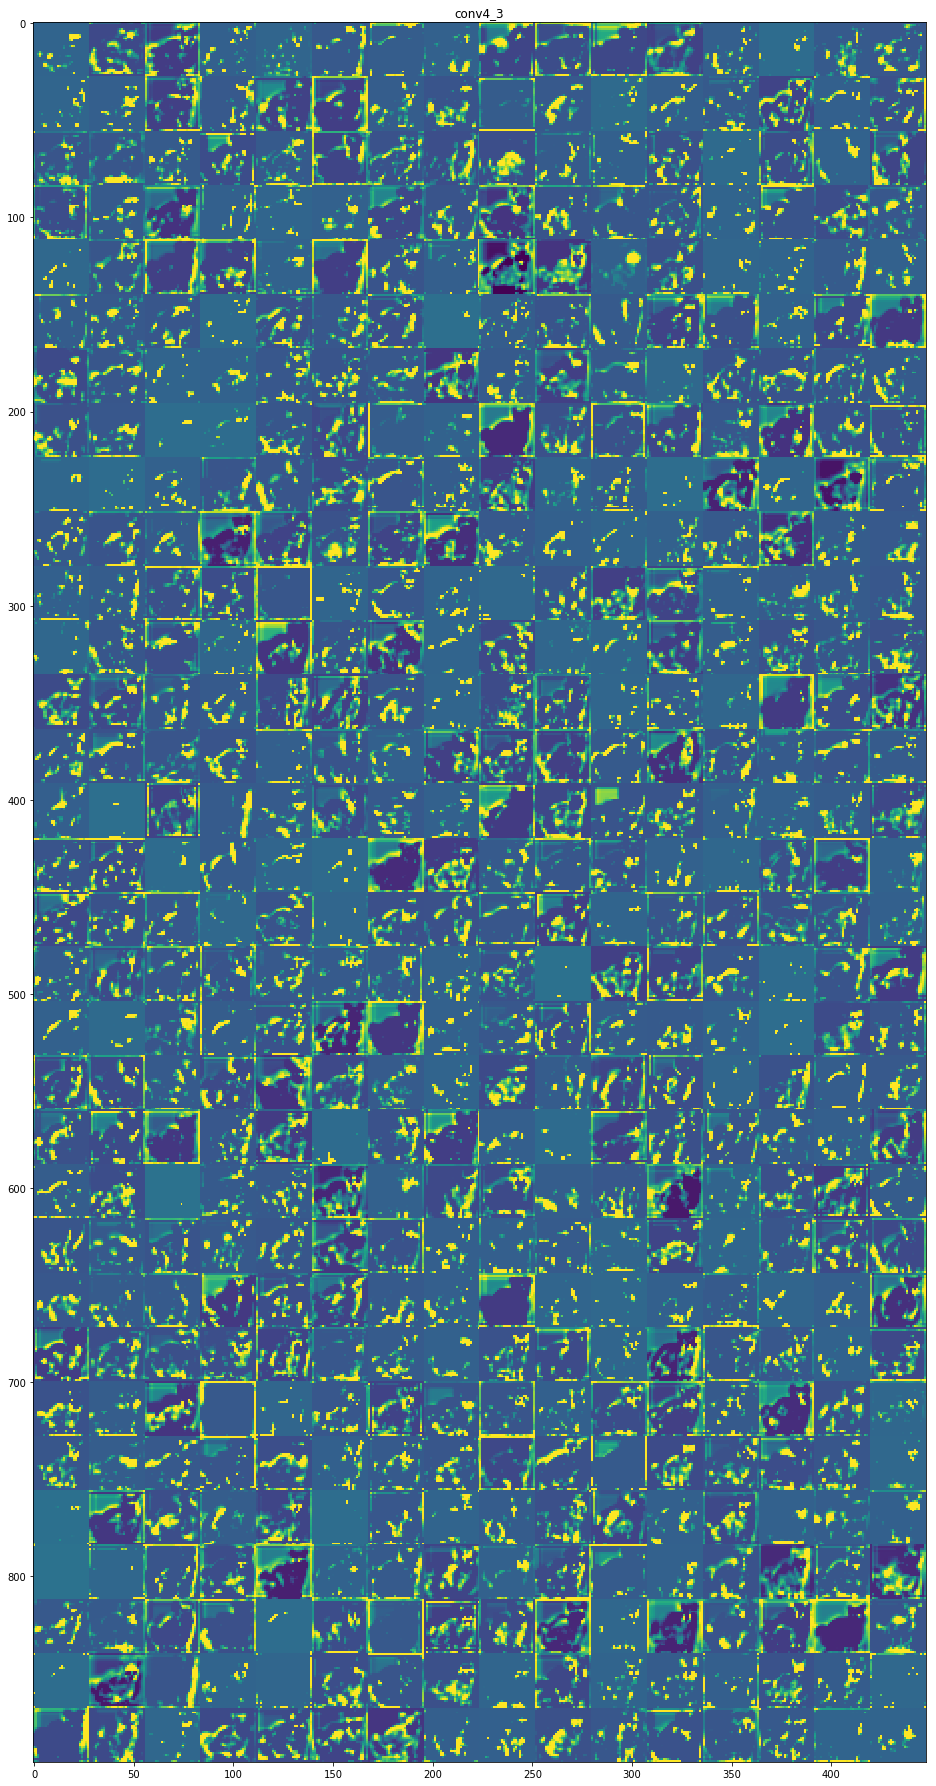

In [30]:
print_all_feature_maps(conv4_3, 'conv4_3')

C:\Users\home\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


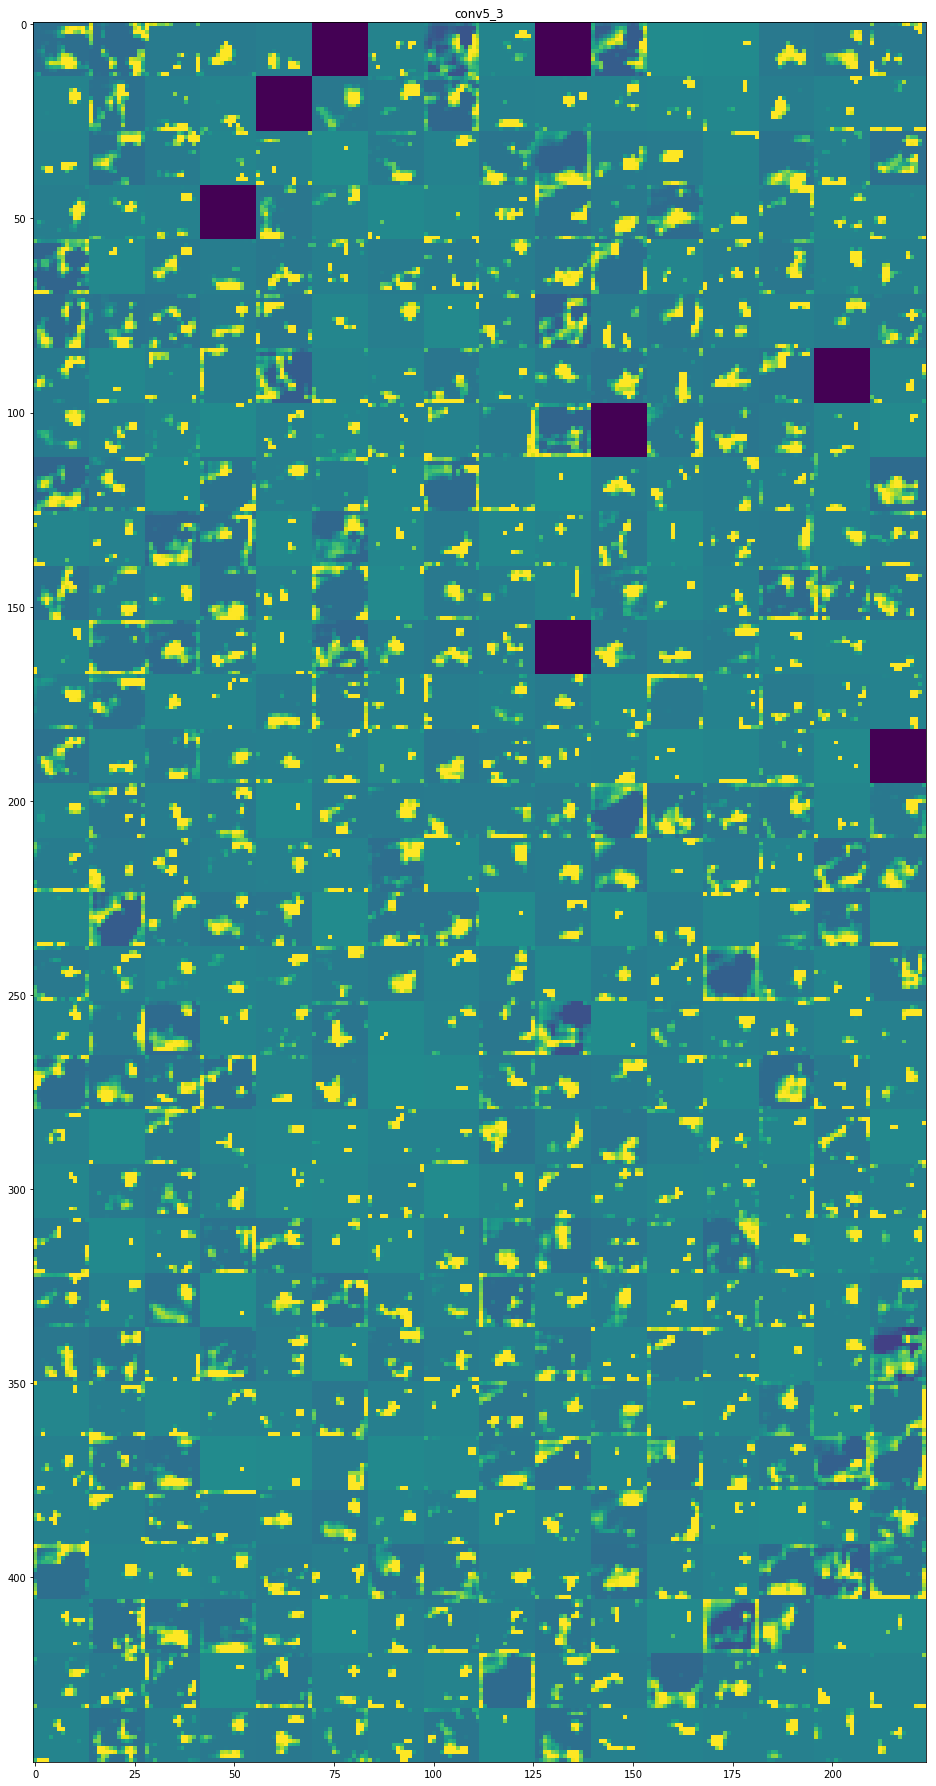

In [31]:
print_all_feature_maps(conv5_3, 'conv5_3')